## Multilayer-perceptron univariate time-series model  

### example: persistence forecast for monthly car sales dataset

In [1]:
from math import sqrt
from numpy import array, mean, std
import pandas as pd 
from pandas import read_csv, concat
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Methods for splitting the dataset into train and test + evaluation metric calculation + model fit&predict

In [2]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    
    return agg.values    

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
#@tf.function
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)

    return yhat[0]

### Methods for model evaluation 

In [3]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    
    return error, predictions

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    predictions_matrix = []
    scores = []
    #scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    for _ in range(n_repeats):
        score, predictions = walk_forward_validation(data, n_test, config) 
        scores.append(score)
        predictions_matrix.append(predictions)
    
    return scores, predictions_matrix

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()


In [36]:
def make_line_plots(title, dataset, attributes_to_plot=[], x_axis_label='x', y_axis_label='y', 
                        background_color=None, legend_location="top_left", line_colors=['red'],
                        x_axis_type=None, tools = "pan,wheel_zoom,box_zoom,reset"):
        try:
            from bokeh.plotting import figure, show, output_file
            from bokeh.models import HoverTool
            from bokeh.io import output_notebook

            output_notebook()

            p = figure(title=title, x_axis_type=x_axis_type, tools=tools, background_fill_color=background_color)
            p.legend.location = legend_location

            x_values = dataset.index
            i = 0
            for attribute in attributes_to_plot:
                    attribute_values = dataset[attribute]
                    p.line(x_values, attribute_values, legend=attribute, line_dash=[4, 4], line_color=line_colors[i], 
                            line_width=2)
                    i += 1


            p.y_range.start = 0
            p.legend.location = legend_location
            p.legend.background_fill_color = background_color
            p.xaxis.axis_label = x_axis_label
            p.yaxis.axis_label = y_axis_label
            p.grid.grid_line_color="white"

            p.add_tools(HoverTool())
            p.select_one(HoverTool).tooltips = [
                                    (x_axis_label, '@x'),
                                    (y_axis_label, '@y'),
                                ]
            p.legend.click_policy="hide"

            show(p)

        except Exception as exc:
            return exc
            #logger.exception('raised exception at {}: {}'.format(logger.name+'.'+make_line_plots.__name__, exc))


### Example with a CHINA EV sales dataset 

In [5]:
#data source: https://datasetsearch.research.google.com/search?query=univariate%20time%20series&docid=Z2B66b7T3lUIl0y6AAAAAA%3D%3D&filters=bm9uZQ%3D%3D&property=aXNfYWNjZXNzaWJsZV9mb3JfZnJlZQ%3D%3D
ev_sales_data = read_csv(r'.\datasets\china_electric_vehicles_sales.csv')

ev_sales_data.iloc[:6]

,Year/Month,BEV,sales
0,2011/01,588,310
1,2011/02,47,417
2,2011/03,159,286
3,2011/04,173,162
4,2011/05,305,470
5,2011/06,319,273


In [6]:
ev_sales_data['Date'] = pd.to_datetime(ev_sales_data['Year/Month'])
ev_sales_data.set_index('Date', inplace=True)
ev_sales_data.drop(columns=['Year/Month'], inplace=True)

sales_series_values = ev_sales_data['sales'].values
ev_sales_data.head(5)

,BEV,sales
Date,,
2011-01-01,588,310
2011-02-01,47,417
2011-03-01,159,286
2011-04-01,173,162
2011-05-01,305,470


In [7]:
ev_sales_data['year'] = pd.Series(ev_sales_data.index).apply(lambda x: x.year).values
ev_sales_data['month'] = pd.Series(ev_sales_data.index).apply(lambda x: x.month).values
ev_sales_data.head(5)

,BEV,sales,year,month
Date,,,,
2011-01-01,588,310,2011,1
2011-02-01,47,417,2011,2
2011-03-01,159,286,2011,3
2011-04-01,173,162,2011,4
2011-05-01,305,470,2011,5


In [37]:
make_line_plots('EV monthly sales', ev_sales_data, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', x_axis_type="datetime")

Loading BokehJS ...

In [10]:
# data split
n_test = 12
# define config: 24 months, 500 nodes for the hidden layer, 100 epochs over all training data samples, 100 evaluated samples every weights update 
config = [24, 500, 100, 100]
# grid search
scores, predictions_matrix = repeat_evaluate(sales_series_values, config, n_test)

> 4645.863
 > 5097.243
 > 4670.296
 > 5056.130
 > 4588.644
 > 4553.794
 > 4953.284
 > 4305.608
 > 4844.605
 > 4842.440
 > 5218.822
 > 5141.776
 > 4653.271
 > 4962.810
 > 4980.499
 > 4936.340
 > 4660.301
 > 4861.792
 > 5143.943
 > 5037.673
 > 4904.412
 > 5008.399
 > 5226.959
 > 4642.851
 > 4997.625
 > 5041.278
 > 4604.962
 > 5087.983
 > 4990.332
 > 5105.731


multilayer perceptron model: 4892.189 RMSE (+/- 224.751)


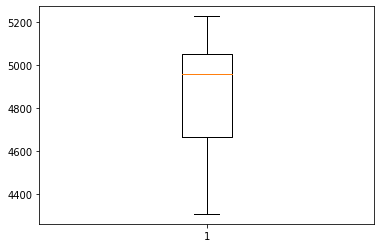

In [11]:
# summarize scores
summarize_scores('multilayer perceptron model', scores)

#### Aquí vemos, como era de esperar, que nuestra red neuronal no es determinista en entrenamiento, así que aunque utilizando varias veces el walk-forward validation method con el consiguiente entrenamiento del modelo, obtenemos distintas predicciones con distintos errores medios cuadráticos <p>
Formamos el dataset con los valores a predecir VS predichos

In [12]:
ev_sales_forecast_df = pd.DataFrame()

test_rmse = measure_rmse(ev_sales_data['sales'][-n_test:].values, predictions_matrix[-1])
if int(test_rmse) == int(scores[-1]): 
    ev_sales_forecast_df['sales_test_values'] = ev_sales_data['sales'][-n_test:]
    ev_sales_forecast_df['sales_baseline_predictions'] = predictions_matrix[-1]

ev_sales_forecast_df

,sales_test_values,sales_baseline_predictions
Date,,
2015-01-01,3148,[5069.294]
2015-02-01,6334,[4284.491]
2015-03-01,4079,[5135.1914]
2015-04-01,5730,[3233.9714]
2015-05-01,6354,[4234.742]
2015-06-01,8308,[2586.9783]
2015-07-01,7338,[3793.7795]
2015-08-01,12085,[2707.4849]
2015-09-01,12736,[8127.2266]


### plot real values VS predicted ones

In [38]:
make_line_plots('EV monthly sales predictions', ev_sales_forecast_df, attributes_to_plot=['sales_test_values', 'sales_baseline_predictions'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue', 'red'], x_axis_type="datetime")

Loading BokehJS ...